(512, 341, 3)
torch.Size([3, 512, 341])


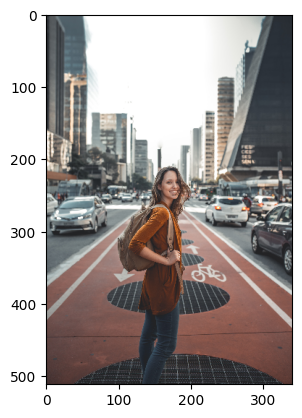

In [3]:
import torch
import torch.nn.functional as F
import numpy as np
import cv2
import random
import math
import copy
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt

image = Image.open('/home/xcai/caixin/RobustVideoMatting/data/matting-dataset/high_res_portrait_ART_team/0001_cloud_input.jpg')
#resize and center padding to 512x512
image = np.array(image)
h, w, _ = image.shape
if h > w:
    scale = 512 / h
    new_w = int(w * scale)
    image = cv2.resize(image, (new_w, 512))
else:
    scale = 512 / w
    new_h = int(h * scale)
    image = cv2.resize(image, (512, new_h))

  
print(image.shape)
image = image.transpose(2, 0, 1)
image = torch.from_numpy(image).float() / 255.0

# image = image.unsqueeze(0)
print(image.shape)
plt.imshow(transforms.ToPILImage()(image))


(0.0, 0.0) 0.0 (0.0, 0.0) (1.0, 1.0)
0.0 341 512
t_scale [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
t_rot [[ 1.  0.  0.]
 [-0.  1.  0.]
 [ 0.  0.  1.]]
t_shear [[ 1.  0. -0.]
 [ 0.  1. -0.]
 [ 0.  0.  1.]]
t_mat_ [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
tensor([0., 0.]) tensor([256.0000, 170.5000])
tensor([[1., 0., 0.],
        [0., 1., 0.]])
torch.Size([512, 341, 2])
(0.0, 0.0) 10 (0.0, 0.0) (1.0, 1.0)
10 341 512
t_scale [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
t_rot [[  0.98480775   0.17364818 -41.86365537]
 [ -0.17364818   0.98480775  33.49622952]
 [  0.           0.           1.        ]]
t_shear [[ 1.  0. -0.]
 [ 0.  1. -0.]
 [ 0.  0.  1.]]
t_mat_ [[  0.98480775   0.17364818 -41.86365537]
 [ -0.17364818   0.98480775  33.49622952]
 [  0.           0.           1.        ]]
tensor([-41.8637,  33.4962]) tensor([256.0000, 170.5000])
tensor([[ 0.9848,  0.1736, -0.1635],
        [-0.1736,  0.9848,  0.1965]])
torch.Size([512, 341, 2])


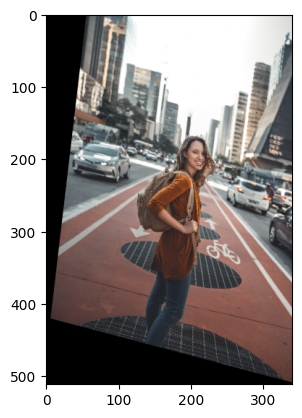

In [29]:
from utils.image.synthesis_helper import get_camera_transformations,get_tmat


  # Initialize lists to store shifts and their inverses
shifts = []
shifts_inv = []
burst_size = 2
downsample_factor = 1
transformation_params = {
    "max_translation": 0,
    "max_rotation": 45,
    "max_shear": 0.,
    "max_scale": 0.,
    "border_crop": None,
}

burst = []

# theta cv2.getRotationMatrix2D((im_w * 0.5, im_h * 0.5), theta, 1.0)

# Initialize lists to store shifts and their inverses
shifts = []
shifts_inv = []

# Prepare meshgrid for sampling
cvs, rvs = torch.meshgrid(
    [torch.arange(0, image.shape[1]),
        torch.arange(0, image.shape[2])],
    indexing='ij')
sample_grid = torch.stack((rvs, cvs, torch.ones_like(rvs)), dim=-1).float()
image_gt = image.clone()

# Generate each image in the burst
for i in range(burst_size):
    if i == 0:
        # Identity transformation for the first image
        shift = (0.0, 0.0)
        theta = 0.0 
        shear_factor = (0.0, 0.0)
        scale_factor = (1.0, 1.0)
    else:
        # Obtain random transformation parameters
        shift, theta, shear_factor, scale_factor = get_camera_transformations(
            downsample_factor, transformation_params)
    print(shift, theta, shear_factor, scale_factor)
    # Compute the affine transformation matrix
    t_mat = get_tmat((image.shape[1], image.shape[2]), shift, theta, shear_factor, scale_factor)
    t_mat_tensor = torch.tensor(t_mat, dtype=torch.float)

    # normalize t_mat_tensor
    print(t_mat_tensor[:2, 2], torch.tensor([image.shape[1] * 0.5, image.shape[2] * 0.5]))
    t_mat_tensor[:2, 2] = t_mat_tensor[:2, 2] / torch.tensor([image.shape[1] * 0.5, image.shape[2] * 0.5]).float()
    print(t_mat_tensor, )
    # Apply affine transformation
    grid = F.affine_grid(t_mat_tensor[None], image[None, :, :, :].shape, align_corners=False)
    image_t = F.grid_sample(image[None, :, :, :].float(), grid, mode='bilinear', padding_mode='zeros', align_corners=False)
    
    image_t = image_t.squeeze()
    plt.imshow(transforms.ToPILImage()(image_t))
    # Convert matrix for tensor operations and compute inverse
    t_mat_tensor_3x3 = torch.cat(
        (t_mat_tensor, torch.tensor([0., 0., 1.]).view(1, 3)),
        dim=0)
    t_mat_tensor_inverse = t_mat_tensor_3x3.inverse()[:2, :].contiguous()

    # Apply inverse transformation to sample grid
    sample_pos_inv = torch.mm(sample_grid.view(-1, 3), t_mat_tensor_inverse.t()).view(*sample_grid.shape[:2], -1)
    print(sample_pos_inv.shape)

    
    #visualize image_t
  
    # break